In [1]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pklfile='ibl_k_nearest_neighbors_1\\contrastive_freezeFalse_seed_42_mlp.pkl'
with open(pklfile, 'rb') as f:
    data = pickle.load(f)
proba_predictions=data["max_proba_predictions"]
test_index=data["test_index"]
test_labels=np.load("../testing_5nn_labels.npy")
labelling={}
correspondence={}
for i in range(len(test_index)):
    labelling[test_index[i]]=test_labels[i]
    correspondence[test_labels[i]]=test_index[i]

In [3]:
with open('../curated_ibl_wvf_acg_pair_wo_root_with_depth_2024-04-30.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
raw_wvfs=data["curated_templates_multi_CH"]
raw_acgs=data["curated_acg3d"]
raw_cosmos=data["curated_cluster_cosmos"]
raw_depth=data["curated_cluster_depth"]
raw_foldidx=data["fold_idx"]
raw_pids=data["curated_pids"]
l=len(raw_wvfs)

In [5]:
pos_pid=list(set(raw_pids))
dic={}
for pid in pos_pid:
    dic[pid]=[]

In [6]:
#test_wvfs=[]
#test_acgs=[]
#test_labels=[]
#test_depth=[]
for i in range(l):
    if raw_foldidx[i] in [3,6]:
        mxind=np.argmax(raw_wvfs[i].ptp(axis=0))
        if mxind-12<0:
            mxind=12
        elif mxind+13>len(raw_wvfs[0][0]):
            mxind=len(raw_wvfs[0][0])-13
        tmpwvf=np.swapaxes(raw_wvfs[i][12:102,mxind-12:mxind+13],0,1).reshape(-1)
        tmpwvf=tmpwvf/max(abs(tmpwvf))
        #test_wvfs.append(tmpwvf)
        #test_acgs.append(raw_acgs[i,:,100:])
        #test_labels.append(raw_cosmos[i])
        #test_depth.append(raw_depth[i])
        lst=[i,tmpwvf,raw_acgs[i,:,100:],raw_cosmos[i],raw_depth[i]]
        dic[raw_pids[i]].append(lst)

In [7]:
tmparr=[]
for i in dic.keys():
    if len(dic[i])>125:
        tmparr.append(i)

In [8]:
ind=0
graphpids=[]
graphinds=[]
for i in sorted(dic.keys()):
    if i not in tmparr:
        ind+=len(dic[i])
        continue
    graphinds.append((ind,ind+len(dic[i])))
    graphpids.append(i)
    ind+=len(dic[i])

In [9]:
graphpids

['1bf5c05b-3654-4d5c-bac9-2b96edd12adf',
 '2ce1d485-ebce-41a2-a5ce-aa109d5a13a3',
 '5245b505-d0e7-4942-94d1-b33a084fab03',
 '9bd71ac6-c455-41f3-8c56-59987a649ac4',
 'afe87fbb-3a17-461f-b333-e22903f1d70d',
 'd0046384-16ea-4f69-bae9-165e8d0aeacf',
 'd1d9defc-6f73-489f-9f14-2c0b5e970b2d',
 'ece878b9-830d-4618-b801-ad0e7d8e7085']

In [10]:
graphinds

[(993, 1198),
 (1452, 1677),
 (2619, 2780),
 (4500, 4644),
 (5135, 5267),
 (5927, 6061),
 (6098, 6255),
 (6917, 7064)]

In [11]:
def process_proba(arr):
    barr=arr.copy()
    for i in range(1,len(barr)):
        barr[i]+=barr[i-1]
    return barr

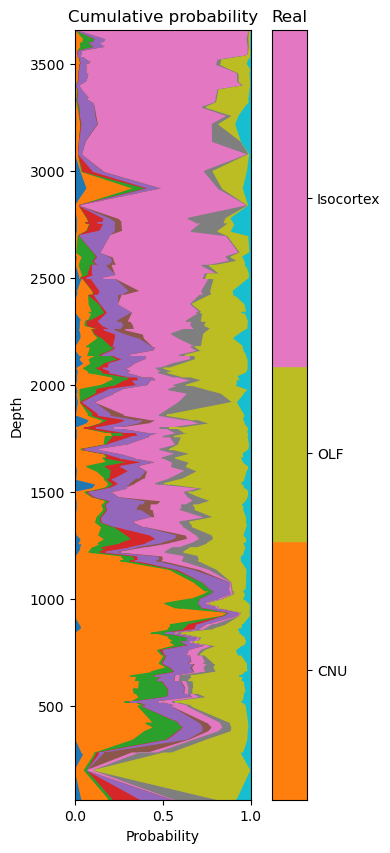

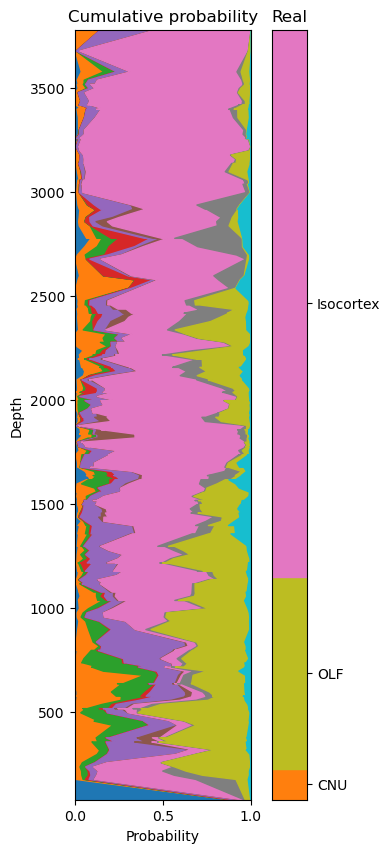

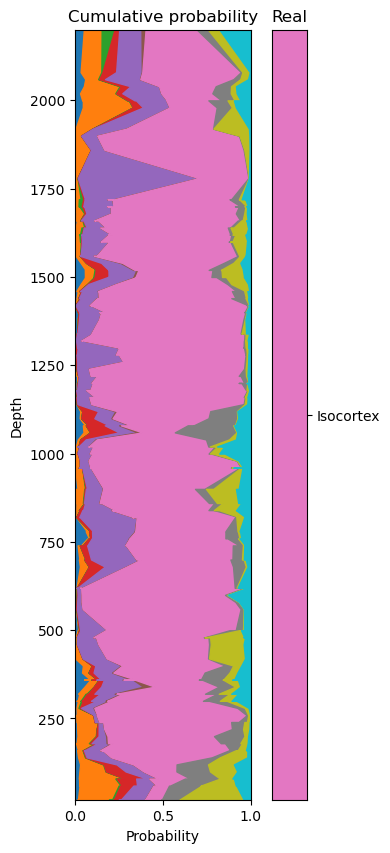

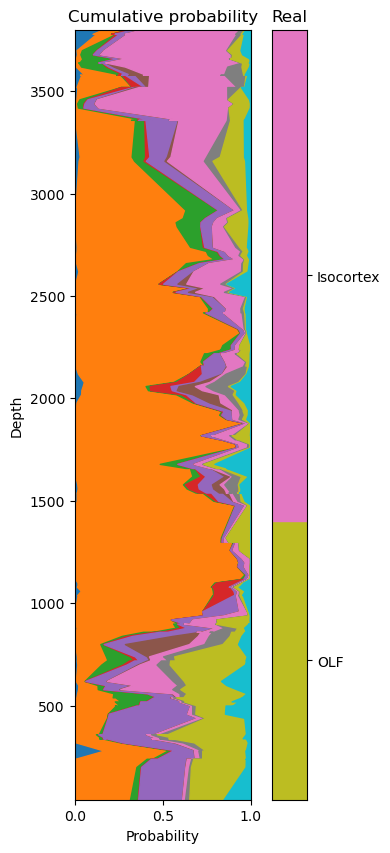

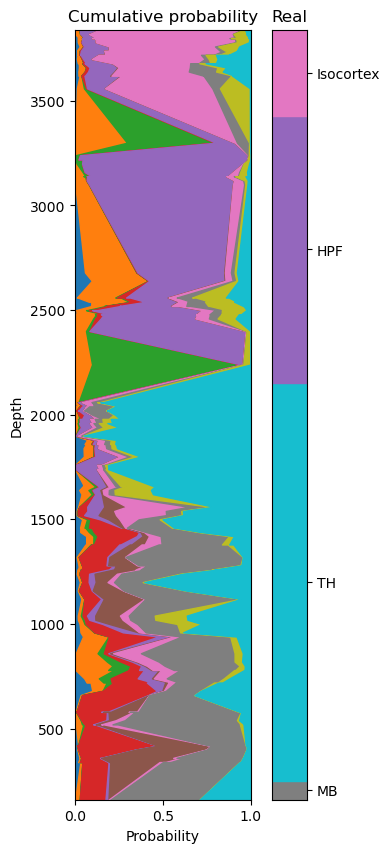

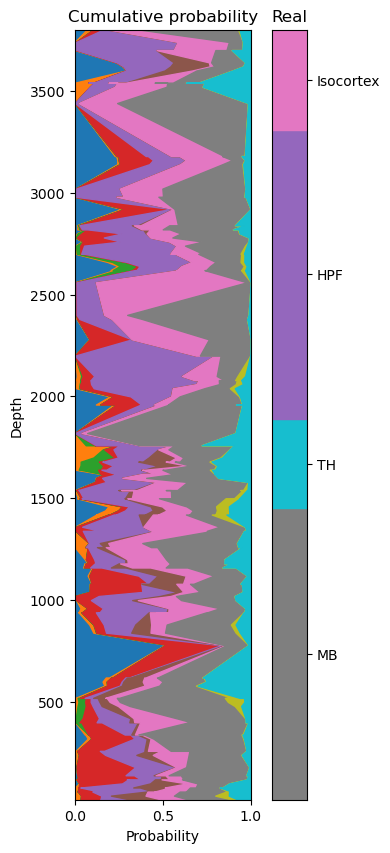

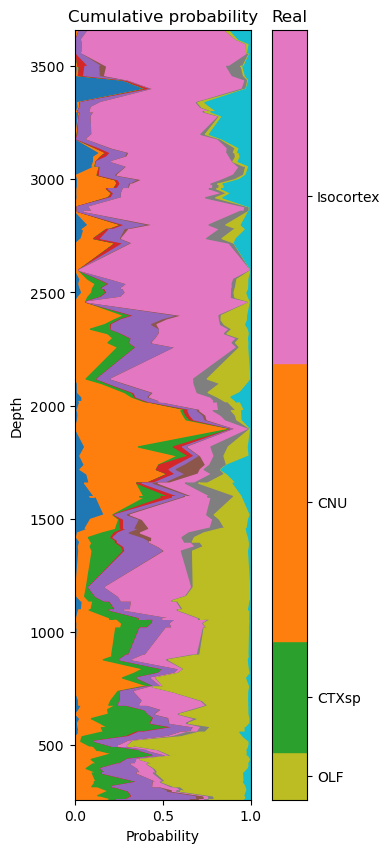

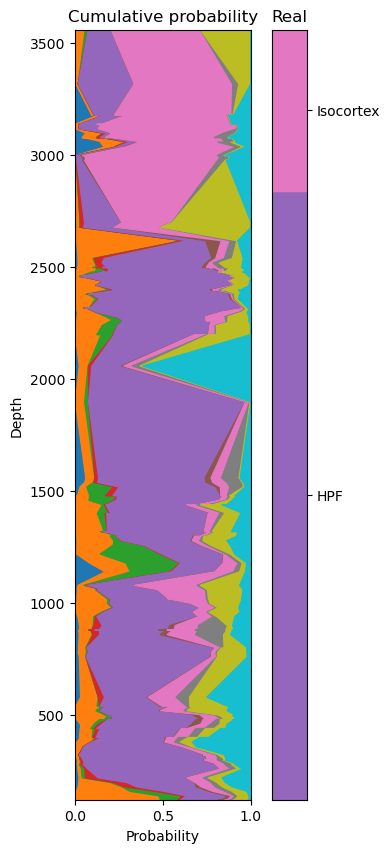

In [19]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(len(graphpids)):
    fig, axs = plt.subplots(1, 2, figsize =[3, 10], width_ratios=[5, 1])

    axs[0].margins(x=0)
    axs[0].margins(y=0)
    axs[1].margins(x=0)
    axs[1].margins(y=0)
    
    pid=graphpids[i]
    lind=graphinds[i][0]
    rind=graphinds[i][1]
    tmparr=[]
    depths=[]
    regions=[]
    indexes=[]
    probs=[]
    for j in range(rind-lind):
        tmparr.append((dic[pid][j][4],dic[pid][j][3],lind+j))
    tmparr.sort()
    for (depth,region,index) in tmparr:
        depths.append(depth)
        regions.append(region)
        indexes.append(index)
        probs.append(process_proba(proba_predictions[index]))
    depths=np.array(depths)
    regions=np.array(regions)
    indexes=np.array(indexes)
    probs=np.array(probs)
    for j in range(10):
        if j==0:
            axs[0].fill_betweenx(depths,0,probs[:,0],color=colors[j])
        else:
            axs[0].fill_betweenx(depths,probs[:,j-1],probs[:,j],color=colors[j])
    axs[0].set_ylabel("Depth")
    axs[0].set_xlabel("Probability")
    axs[0].set_title("Cumulative probability")
    l=0
    r=0
    yti=[]
    ytilabels=[]
    while r<len(regions):
        if regions[l]==regions[r]:
            r+=1
        else:
            fillarr=depths[l:r]
            if l!=0:
                fillarr=np.insert(fillarr,0,(depths[l]+depths[l-1])/2)
            fillarr=np.insert(fillarr,len(fillarr),(depths[r]+depths[r-1])/2)
            
            yti.append((fillarr[0]+fillarr[-1])/2)
            ytilabels.append(regions[l])
            
            axs[1].fill_betweenx(fillarr,0,1,color=colors[correspondence[regions[l]]])
            l=r
            r+=1
    fillarr=depths[l:r]
    if l!=0:
        fillarr=np.insert(fillarr,0,(depths[l]+depths[l-1])/2)
    
    yti.append((fillarr[0]+fillarr[-1])/2)
    ytilabels.append(regions[l])   
    
    axs[1].fill_betweenx(fillarr,0,1,color=colors[correspondence[regions[l]]])
    axs[1].set_title("Real")
    axs[1].get_xaxis().set_ticks([])
    axs[1].yaxis.set_label_position("right")
    axs[1].set_yticks(yti)
    axs[1].set_yticklabels(ytilabels)
    axs[1].yaxis.tick_right()
    plt.savefig("pids/"+pid+".png")

In [13]:
graphpids

['1bf5c05b-3654-4d5c-bac9-2b96edd12adf',
 '2ce1d485-ebce-41a2-a5ce-aa109d5a13a3',
 '5245b505-d0e7-4942-94d1-b33a084fab03',
 '9bd71ac6-c455-41f3-8c56-59987a649ac4',
 'afe87fbb-3a17-461f-b333-e22903f1d70d',
 'd0046384-16ea-4f69-bae9-165e8d0aeacf',
 'd1d9defc-6f73-489f-9f14-2c0b5e970b2d',
 'ece878b9-830d-4618-b801-ad0e7d8e7085']